<a href="https://colab.research.google.com/github/eyalgur1/Computer_Vision/blob/main/1_Image_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2 as cv2
from keras.preprocessing.image import load_img
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# LaTeX and Google Drive configuration

!sudo apt-get update
!sudo apt-get install -y texlive texlive-latex-extra dvipng texlive-fonts-recommended cm-super


plt.rcParams.update({
    "text.usetex": True,             # Use LaTeX for all text
    "font.family": "serif",          # Use serif fonts
    "font.serif": ["Computer Modern Roman"],  # Use Computer Modern Roman font
    "text.latex.preamble": r"\usepackage{amsmath}",  # Load additional packages
    "font.size": 16,                 # Default font size
    "axes.titlesize": 16,            # Title font size
    "axes.labelsize": 16,            # Axis labels font size
    "xtick.labelsize": 10,           # X-tick labels font size
    "ytick.labelsize": 10,           # Y-tick labels font size
    "legend.fontsize": 14            # Legend font size
})

from google.colab import drive
drive.mount("/content/drive/")

## **Image Point Processing Operations**

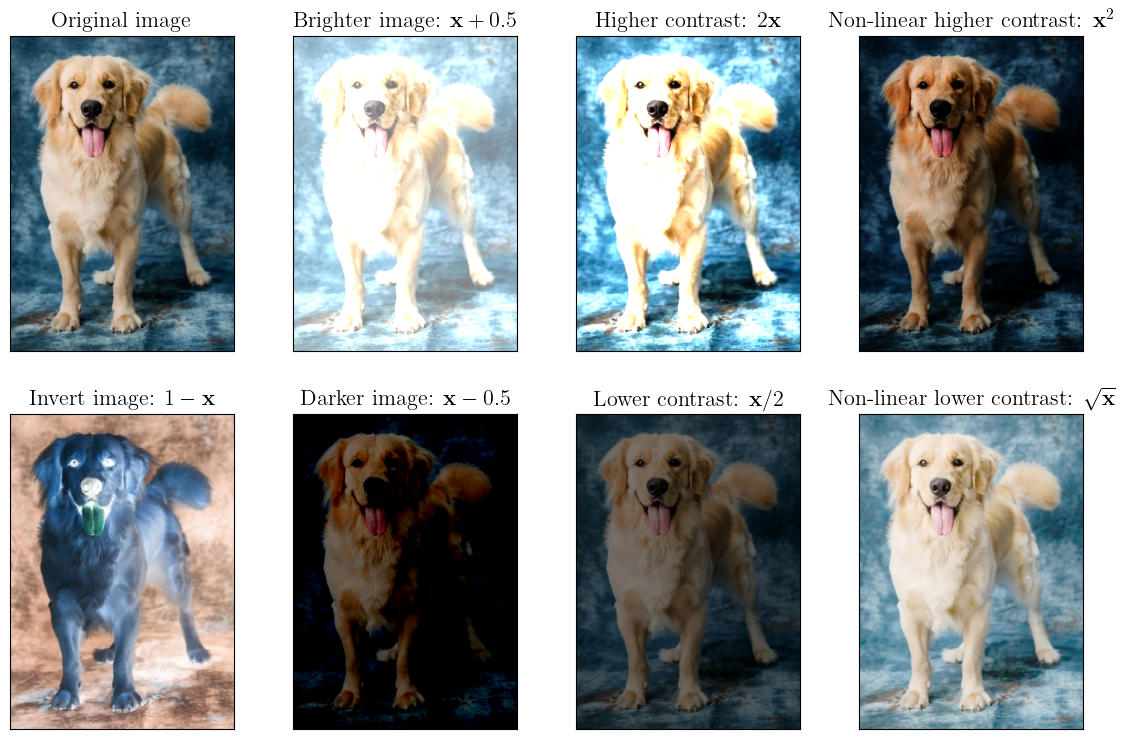

In [3]:
image_cv2 = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/dog.PNG', 1)
# flag=1 for color images, flag=0 for grayscale; loads in 8-bit format (integers from 0 to 255)

image = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)/255.0
# BGR is the default format of cv2, while RGB is the format matplotlib expects
# matplotlib expects range of [0,1] for floats and [0,...,255] for integers, so we divide by 255.0 to tranform to floats of [0,1] (more convinient handling)

f, ax = plt.subplots(2,4, figsize=(14,9))
ax[0,0].imshow(image); ax[0,0].set_title('Original image')  # display original image
ax[1,0].imshow(1-image); ax[1,0].set_title('Invert image: $1-\mathbf{x}$')  # display original image
# matplotlib automatically scales to the range [0,1] for floats

ax[0,1].imshow(image + 0.5); ax[0,1].set_title('Brighter image: $\mathbf{x}+0.5$')  # display brighter image
ax[1,1].imshow(image - 0.5); ax[1,1].set_title('Darker image: $\mathbf{x}-0.5$')
# matplotlib first clips values out of range [0,1] to the nearest edge value, and then scales to [0,1] for floats

ax[0,2].imshow(image*2); ax[0,2].set_title('Higher contrast: $2\mathbf{x}$')
ax[1,2].imshow(image/2); ax[1,2].set_title('Lower contrast: $\mathbf{x}/2$')

ax[0,3].imshow(image**2); ax[0,3].set_title('Non-linear higher contrast: $\mathbf{x}^{2}$')
ax[1,3].imshow(image**(1/2)); ax[1,3].set_title('Non-linear lower contrast: $\sqrt{\mathbf{x}}$')

# remove xticks and yticks
for i in range (2):
  for j in range (4):
    ax[i,j].set_xticks([]); ax[i,j].set_yticks([])
plt.show()

## **Box Filtering**

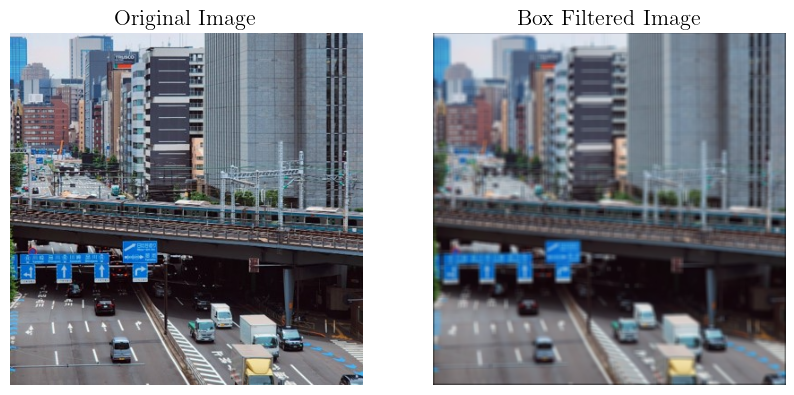

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_box_filter(image, kernel_size):
    # Get the dimensions of the image
    height, width, channels = image.shape

    # Create the box filter (kernel matrix) with uniform weights
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size**2)

    # Calculate the padding needed for the kernel
    pad_h = kernel_size // 2
    pad_w = kernel_size // 2

    # Pad the image with zeros on the border
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant', constant_values=0)

    # Initialize the output image
    filtered_image = np.zeros_like(image)

    # Perform the convolution operation
    for y in range(height):
        for x in range(width):
            for c in range(channels):
                # Extract the region of interest (ROI) corresponding to the current position
                roi = padded_image[y:y + kernel_size, x:x + kernel_size, c]

                # Apply the box filter (element-wise multiplication and sum)
                filtered_pixel = np.sum(roi * kernel)  # since this colnvolution is symmetric, we can just take element-wise multiplication and sum

                # Assign the filtered value to the output image
                filtered_image[y, x, c] = filtered_pixel

    return filtered_image

# Load the RGB image using OpenCV
image_cv2 = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/road.jpg', 1)

# Convert the image from BGR (OpenCV default) to RGB
image = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)/255.0

# Define the size of the box filter (kernel size)
kernel_size = 5  # This is a 5x5 box filter

# Apply the custom box filter function
filtered_image = apply_box_filter(image, kernel_size)

# Display the original and filtered images using matplotlib
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Filtered image
plt.subplot(1, 2, 2)
plt.imshow(filtered_image)
plt.title('Box Filtered Image')
plt.axis('off')

plt.show()

## **Gauusian Filter Using two 1D Convolutions**

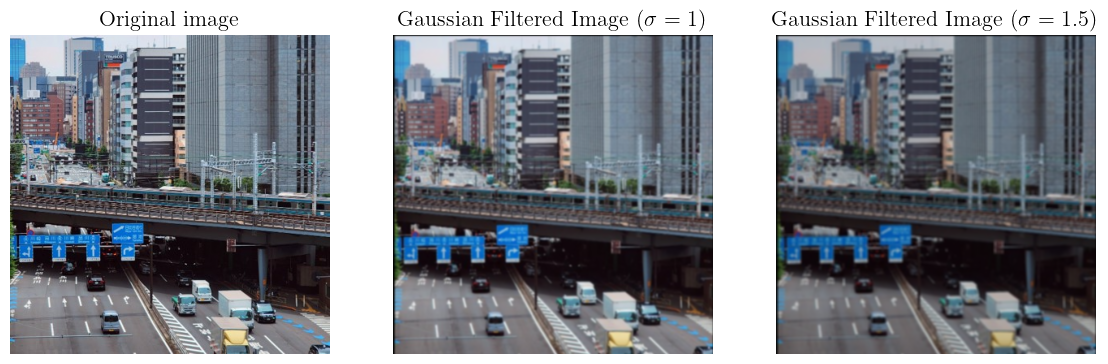

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gaussian_1d_kernel(size, sigma):
    """Generate a 1D Gaussian kernel."""
    kernel = np.arange(-(size//2), size//2 + 1)
    kernel = np.exp(-0.5 * (kernel ** 2) / sigma ** 2)
    kernel = kernel / (np.sqrt(2*np.pi)*sigma)
    return kernel

def apply_1d_convolution(image, kernel, axis):
    """Apply a 1D convolution along a specified axis (0 for rows, 1 for columns)."""
    # Pad the image to handle the edges
    pad_width = len(kernel) // 2
    padded_image = np.pad(image, ((pad_width, pad_width), (pad_width, pad_width), (0, 0)), mode='constant', constant_values=0)

    # Initialize the output image
    output = np.zeros_like(image)

    # Perform 1D convolution along the specified axis
    if axis == 0:  # Convolution along rows
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                for c in range(image.shape[2]):
                    output[i, j, c] = np.sum(padded_image[i:i + len(kernel), j, c] * kernel)  # the kernel is symmetric, so we can take element-wise multiplication
    elif axis == 1:  # Convolution along columns
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                for c in range(image.shape[2]):
                    output[i, j, c] = np.sum(padded_image[i, j:j + len(kernel), c] * kernel)

    return output

def apply_gaussian_filter(kernel_size, image, sigma):
    """Apply a Gaussian filter using separable 1D convolutions."""
    # Generate the 1D Gaussian kernel
    gaussian_kernel = gaussian_1d_kernel(kernel_size, sigma)

    # Apply the 1D Gaussian kernel along the rows
    row_filtered_image = apply_1d_convolution(image, gaussian_kernel, axis=0)

    # Apply the 1D Gaussian kernel along the columns
    gaussian_filtered_image = apply_1d_convolution(row_filtered_image, gaussian_kernel, axis=1)

    return gaussian_filtered_image

# Load the image using OpenCV
image_cv2 = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/road.jpg', 1)

# Convert the image from BGR to RGB
image = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)/255.0

# Apply the Gaussian filter
sigma = (1, 1.5)  # Standard deviation for the Gaussian filter
gaussian_filtered_image = apply_gaussian_filter(kernel_size=5, image=image, sigma=sigma[0])
gaussian_filtered_image_2 = apply_gaussian_filter(kernel_size=5, image=image, sigma=sigma[1])

# Display the original and Gaussian-filtered images
f, ax = plt.subplots(1,3, figsize=(14,9))

# Original image
ax[0].imshow(image); ax[0].set_title('Original image')  # display original image
ax[0].axis('off')

# Gaussian filtered image
ax[1].imshow(gaussian_filtered_image); ax[1].set_title(f'Gaussian Filtered Image ($\sigma={sigma[0]}$)')
ax[1].axis('off')

# Gaussian filtered image
ax[2].imshow(gaussian_filtered_image_2); ax[2].set_title(f'Gaussian Filtered Image ($\sigma={sigma[1]}$)')
ax[2].axis('off')

plt.show()


## **Sharpening Filter**

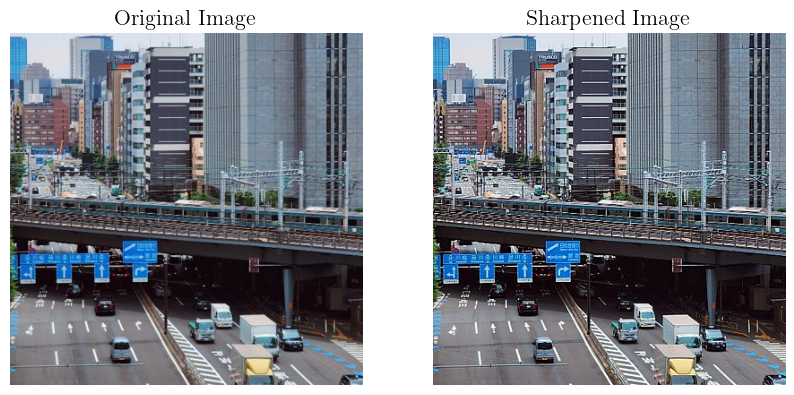

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_sharpening_filter(image):
    # Define the 3x3 sharpening filter kernel
    # Step 1: Double the pixel (center of the kernel is 2)
    kernel_double = np.array([
        [0, 0, 0],
        [0, 2, 0],
        [0, 0, 0]
    ])

    # Step 2: Subtract the box filter (averaging filter)
    box_filter = np.ones((3, 3)) / 9.0

    # Combined sharpening filter: Double the pixel and subtract the box filter
    sharpening_kernel = kernel_double - box_filter

    # Apply the sharpening filter using cv2.filter2D
    sharpened_image = cv2.filter2D(image, -1, sharpening_kernel)  # -1 will give the output image datatype (64FP etc) as same as the input image

    return sharpened_image

# Load the image using OpenCV
image_cv2 = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/road.jpg', 1)

# Convert the image from BGR to RGB
image = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)/255.0

# Apply the sharpening filter
sharpened_image = apply_sharpening_filter(image)

# Display the original and sharpened images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Sharpened image
plt.subplot(1, 2, 2)
plt.imshow(sharpened_image)
plt.title('Sharpened Image')
plt.axis('off')

plt.show()


## **Edge Detection Using the Sobel and Prewitt Filters**

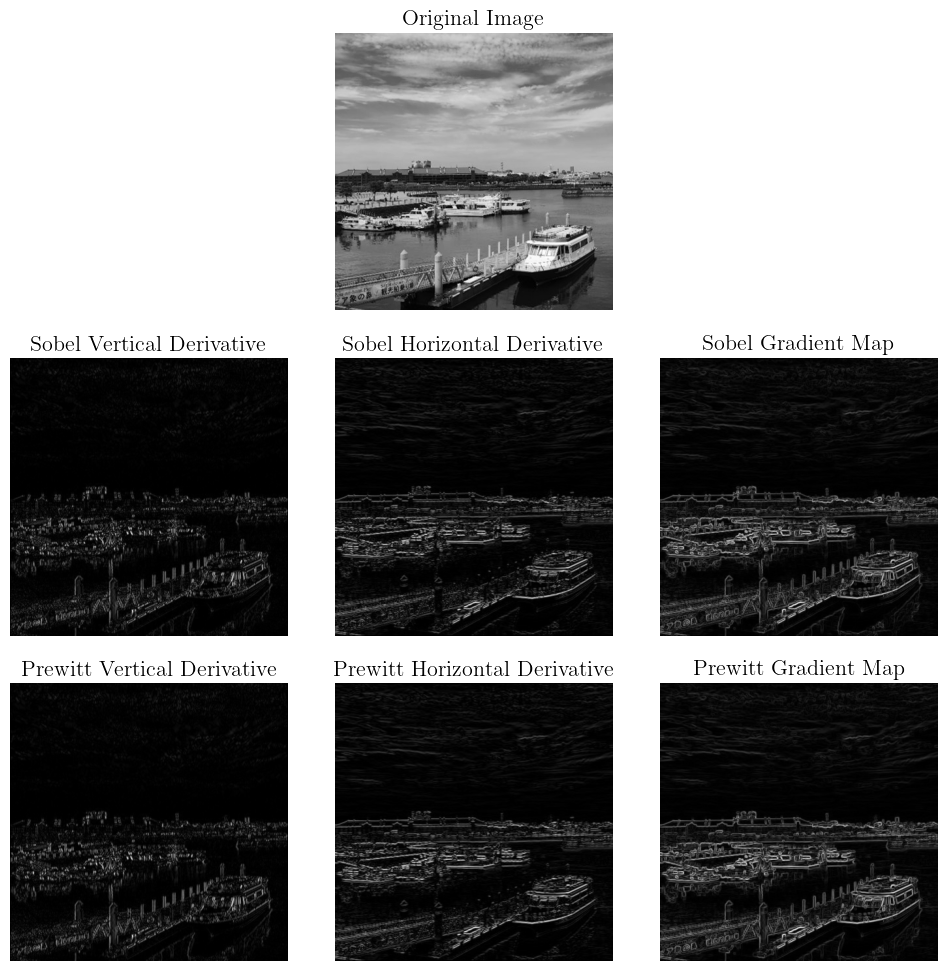

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_gradient(image, filter_type='sobel'):
    if filter_type == 'sobel':
        # Sobel filters for x and y directions
        kernel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
        kernel_y = np.transpose(kernel_x)
        grad_x = cv2.filter2D(image, -1, kernel_x)  # -1 will give the output image datatype (64FP etc) as same as the input image
        grad_y = cv2.filter2D(image, -1, kernel_y)
    elif filter_type == 'prewitt':
        # Prewitt filters for x and y directions
        kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        kernel_y = np.transpose(kernel_x)
        grad_x = cv2.filter2D(image, -1, kernel_x)
        grad_y = cv2.filter2D(image, -1, kernel_y)
    else:
        raise ValueError("Invalid filter type. Use 'sobel' or 'prewitt'.")

    # Calculate gradient magnitude
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    return grad_x, grad_y, gradient_magnitude

# Load the image in grayscale
image = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ship.jpg', 0)/255.0
# flag=1 for color images, flag=0 for grayscale; loads in 8-bit format (integers from 0 to 255)
# By dividing by 255.0 we transform to 64FP for better computations
# Here we use grayscale brcause our aim is edge detection, so there is no need for other channels

# Compute gradient maps using Sobel filter
sobel_grad_x, sobel_grad_y, sobel_gradient = compute_gradient(image, filter_type='sobel')

# Compute gradient maps using Prewitt filter
prewitt_grad_x, prewitt_grad_y, prewitt_gradient = compute_gradient(image, filter_type='prewitt')

# Plot the original image, vertical and horizontal derivatives, and the gradient maps
plt.figure(figsize=(10, 10))

# Original image
plt.subplot(3, 3, 2)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Sobel vertical derivative
plt.subplot(3, 3, 4)
plt.imshow(np.abs(sobel_grad_x), cmap='gray')
plt.title('Sobel Vertical Derivative')
plt.axis('off')

# Sobel horizontal derivative
plt.subplot(3, 3, 5)
plt.imshow(np.abs(sobel_grad_y), cmap='gray')
plt.title('Sobel Horizontal Derivative')
plt.axis('off')

# Sobel gradient map
plt.subplot(3, 3, 6)
plt.imshow(sobel_gradient, cmap='gray')
plt.title('Sobel Gradient Map')
plt.axis('off')

# Prewitt vertical derivative
plt.subplot(3, 3, 7)
plt.imshow(np.abs(prewitt_grad_x), cmap='gray')
plt.title('Prewitt Vertical Derivative')
plt.axis('off')

# Prewitt horizontal derivative
plt.subplot(3, 3, 8)
plt.imshow(np.abs(prewitt_grad_y), cmap='gray')
plt.title('Prewitt Horizontal Derivative')
plt.axis('off')

# Prewitt gradient map
plt.subplot(3, 3, 9)
plt.imshow(prewitt_gradient, cmap='gray')
plt.title('Prewitt Gradient Map')
plt.axis('off')

plt.tight_layout()
plt.show()


## **Gradient Map of Noisy Images**

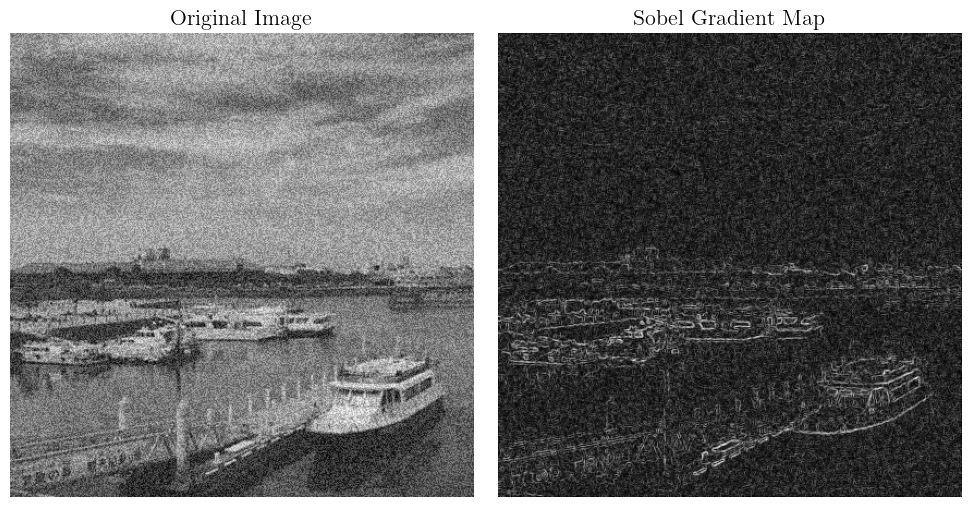

In [8]:
# Load the image in grayscale
image = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ship.jpg', 0)/255.0
# flag=1 for color images, flag=0 for grayscale; loads in 8-bit format (integers from 0 to 255)
# By dividing by 255.0 we transform to 64FP for better computations
# Here we use grayscale brcause our aim is edge detection, so there is no need for other channels

# Add random noise to the image
noise = 0.5*np.random.rand(*image.shape)
noisy_image = image + noise

# Compute gradient maps using Sobel filter
_, _, sobel_gradient = compute_gradient(noisy_image, filter_type='sobel')

# Plot the original image, vertical and horizontal derivatives, and the gradient maps
plt.figure(figsize=(10, 10))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(noisy_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Sobel gradient map
plt.subplot(1, 2, 2)
plt.imshow(sobel_gradient, cmap='gray')
plt.title('Sobel Gradient Map')
plt.axis('off')

plt.tight_layout()
plt.show()

## **Derivative of Gaussain (DoG) Filter**

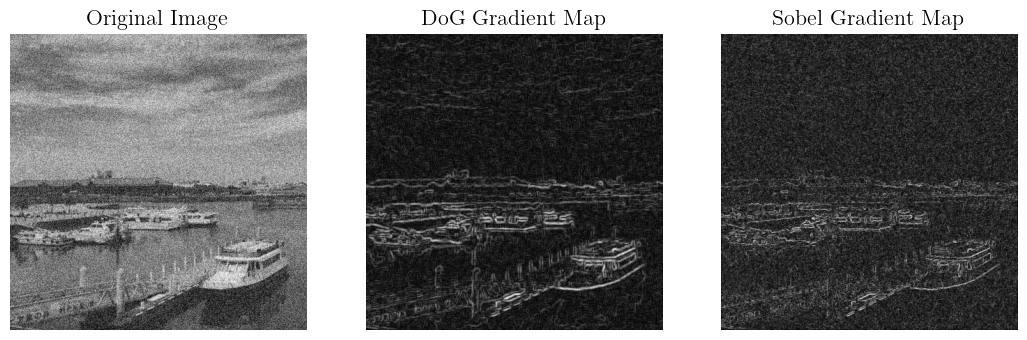

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gaussian_1d(sigma, size):
    """Generate a 1D Gaussian kernel."""
    ax = np.arange(-(size//2), size//2 + 1)
    gaussian = np.exp(-0.5 * (ax / sigma) ** 2)
    gaussian = np.array([gaussian]) / (np.sqrt(2*np.pi)*sigma)
    return gaussian  # returns a 1D Gaussian kernel of size [1,size] (row vector)

def derivative_of_gaussian_1d(sigma, size):
    """Generate a 1D derivative of Gaussian kernel."""
    ax = np.arange(-(size//2), size//2 + 1)
    derivative_gaussian = (-2*ax/(sigma**2)) * np.exp(-0.5 * (ax / sigma) ** 2)
    derivative_gaussian = np.array([derivative_gaussian]) / (np.sqrt(2*np.pi)*sigma)  # returns a 1D Gaussian kernel of size [1,size] (row vector)
    return derivative_gaussian   # returns a 1D DoG kernel of size [1,size] (row vector)

def apply_separable_dog(image, sigma=1.0, size=5):
    """Apply the 2D Derivative of Gaussian filter to an image using separable kernels."""
    # Generate 1D Gaussian and Derivative of Gaussian kernels
    gaussian_1d_kernel = gaussian_1d(sigma, size)
    dog_1d_kernel = derivative_of_gaussian_1d(sigma, size)

    # Convolve with the derivative in the x-direction
    gradient_x = cv2.filter2D(image, -1, np.transpose(dog_1d_kernel))

    # Convolve with the Gaussian in the x-direction
    gradient_x = cv2.filter2D(gradient_x, -1, gaussian_1d_kernel)

    # Convolve with the derivative in the y-direction
    gradient_y = cv2.filter2D(image, -1, np.transpose(gaussian_1d_kernel))

    # Convolve with the Gaussian in the x-direction
    gradient_y = cv2.filter2D(gradient_y, -1, dog_1d_kernel)

    # Compute the gradient magnitude
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    return gradient_magnitude

image = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ship.jpg', 0)/255.0
# flag=1 for color images, flag=0 for grayscale; loads in 8-bit format (integers from 0 to 255)
# By dividing by 255.0 we transform to 64FP for better computations
# Here we use grayscale brcause our aim is edge detection, so there is no need for other channels

# Add random noise to the image
noise = 0.5*np.random.rand(*image.shape)
noisy_image = image + noise
# Load the image in grayscale

# Apply the DoG filter
gradient_map = apply_separable_dog(noisy_image, sigma=50, size=5)

# Apply Sobel filter for comparison
_, _, sobel_gradient = compute_gradient(noisy_image, filter_type='sobel')

# Plot the original image and the gradient map
plt.figure(figsize=(13, 11))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(noisy_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Gradient map
plt.subplot(1, 3, 2)
plt.imshow(gradient_map, cmap='gray')
plt.title('DoG Gradient Map')
plt.axis('off')

# Gradient map
plt.subplot(1, 3, 3)
plt.imshow(sobel_gradient, cmap='gray')
plt.title('Sobel Gradient Map')
plt.axis('off')

plt.show()


## **Laplacian Filters**

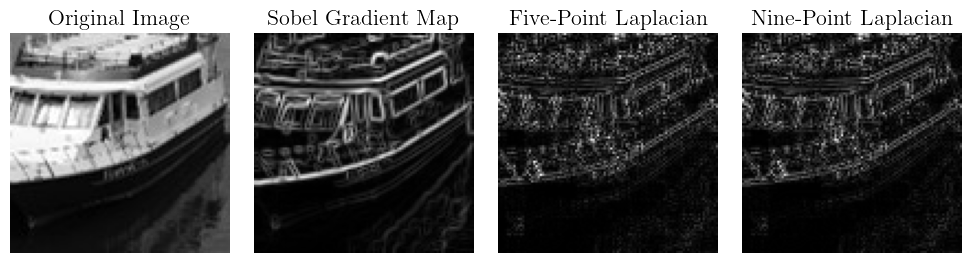

In [10]:
def laplace_filter(image, filter_type='five_point'):
    if filter_type == 'five_point':
        kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
        hess = cv2.filter2D(image, -1, kernel)  # -1 will give the output image datatype (64FP etc) as same as the input image
    elif filter_type == 'nine_point':
        kernel = np.array([[0.25, 0.5, 0.25], [0.5, -3, 0.5], [0.25, 0.5, 0.25]])
        hess = cv2.filter2D(image, -1, kernel)
    else:
        raise ValueError("Invalid filter type. Use 'five_point' or 'nine_point'.")
    return hess


# Load the image in grayscale
image = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ship.jpg', 0)/255.0
# flag=1 for color images, flag=0 for grayscale; loads in 8-bit format (integers from 0 to 255)
# By dividing by 255.0 we transform to 64FP for better computations
# Here we use grayscale brcause our aim is edge detection, so there is no need for other channels

# Set a portion of the image for better visualization
image = image[300:400,300:400]

# Compute gradient maps using Sobel filter
_, _, sobel_gradient = compute_gradient(image, filter_type='sobel')

# Compute second-order derivative using Five-Point Laplacian
hess_five = laplace_filter(image, filter_type='five_point')

# Compute second-order derivative using Nine-Point Laplacian
hess_nine = laplace_filter(image, filter_type='nine_point')

# Plot the original image, vertical and horizontal derivatives, and the gradient maps
plt.figure(figsize=(10, 10))

# Original image
plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Sobel gradient map
plt.subplot(1, 4, 2)
plt.imshow(sobel_gradient, cmap='gray')
plt.title('Sobel Gradient Map')
plt.axis('off')

# Five-Point Laplacian
plt.subplot(1, 4, 3)
plt.imshow(np.abs(hess_five), cmap='gray')
plt.title('Five-Point Laplacian')
plt.axis('off')

# Nine-Point Laplacian
plt.subplot(1, 4, 4)
plt.imshow(np.abs(hess_nine), cmap='gray')
plt.title('Nine-Point Laplacian')
plt.axis('off')

plt.tight_layout()
plt.show()

## **LoG Filter**

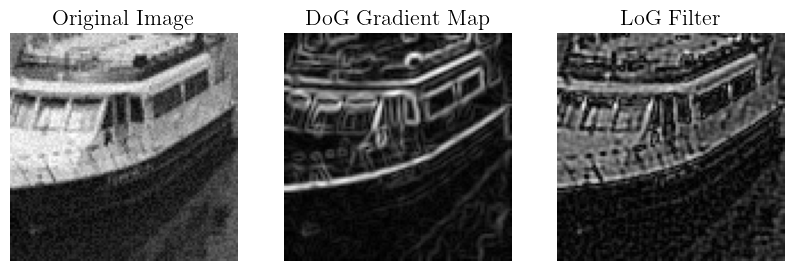

In [11]:
def gaussian_1d(sigma, size):
    """Generate a 1D Gaussian kernel."""
    ax = np.arange(-(size//2), size//2 + 1)
    gaussian = np.exp(-0.5 * (ax / sigma) ** 2)
    gaussian = np.array([gaussian]) / (np.sqrt(2*np.pi)*sigma)
    return gaussian  # returns a 1D Gaussian kernel of size [1,size] (row vector)

def second_derivative_of_gaussian_1d(sigma, size):
    """Generate a 1D second derivative of Gaussian kernel."""
    ax = np.arange(-(size//2), size//2 + 1)
    second_derivative_gaussian = ((ax**2/sigma**4)-(1/(sigma**2))) * np.exp(-0.5 * (ax / sigma) ** 2)
    second_derivative_gaussian = np.array([second_derivative_gaussian]) / (np.sqrt(2*np.pi)*sigma)
    return second_derivative_gaussian   # returns a 1D LoG kernel of size [1,size] (row vector)

def apply_separable_log(image, sigma=1.0, size=5):
    """Apply the 2D Derivative of Gaussian filter to an image using separable kernels."""
    # Generate 1D Gaussian and Second Derivative of Gaussian kernels
    gaussian_1d_kernel = gaussian_1d(sigma, size)
    log_1d_kernel = second_derivative_of_gaussian_1d(sigma, size)

    # Convolve with the derivative in the x-direction
    derivative_xx = cv2.filter2D(image, -1, np.transpose(log_1d_kernel))

    # Convolve with the Gaussian in the x-direction
    derivative_xx = cv2.filter2D(derivative_xx, -1, gaussian_1d_kernel)

    # Convolve with the derivative in the y-direction
    derivative_yy = cv2.filter2D(image, -1, np.transpose(gaussian_1d_kernel))

    # Convolve with the Gaussian in the x-direction
    derivative_yy = cv2.filter2D(derivative_yy, -1, log_1d_kernel)

    # Compute the gradient magnitude
    log_filtered_image = derivative_xx + derivative_yy

    return log_filtered_image

image = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ship.jpg', 0)/255.0
# flag=1 for color images, flag=0 for grayscale; loads in 8-bit format (integers from 0 to 255)
# By dividing by 255.0 we transform to 64FP for better computations
# Here we use grayscale brcause our aim is edge detection, so there is no need for other channels

# Add random noise to the image
noise = 0.15*np.random.rand(*image.shape)
noisy_image = image + noise
# Load the image in grayscale

# Set a portion of the image for better visualization
noisy_image = noisy_image[300:400,300:400]

# Apply the DoG filter
gradient_map = apply_separable_dog(noisy_image, sigma=1, size=5)

# Apply the LoG filter
log_image = apply_separable_log(noisy_image, sigma=1, size=5)

plt.figure(figsize=(10, 10))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(noisy_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# DoG Filter
plt.subplot(1, 3, 2)
plt.imshow(gradient_map, cmap='gray')
plt.title('DoG Gradient Map')
plt.axis('off')

# Five-Point Laplacian
plt.subplot(1, 3, 3)
plt.imshow(np.abs(log_image), cmap='gray')
plt.title('LoG Filter')
plt.axis('off')
plt.show()